## Introduction

This file contains all the code necessary to develop, run, and analyze a long
short-term memory neural network for the purposes of stock price forecasting.
Feel free to mess around with the ticker and various hyperparameters. This model
alone isn't sufficient to trade profitably, but is a nice proof of concept and
starting point.

The following sources were used:

"_181 - Multivariate time series forecasting using LSTM_" \
https://www.youtube.com/watch?v=tepxdcepTbY

"_Stock Price Prediction & Forecasting with LSTM Neural Networks in Python_" \
https://www.youtube.com/watch?v=tepxdcepTbY

### 1) Get stock data, trim the data.
This section of code gets the stock data, and trims the various parameters to
prepare the dataframe for processing.

In [49]:
# Imports
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

################################################################################

# Define a string to be our ticker of interest.
ticker = "SPY"

# Download relevant ticker data, using data from the inception of the ticker to
# the last possible date.
ticker_df = yf.download(ticker, period="max")

# Arbitrarily, let's choose to predict the open of the stock, using
# only the open, high, low and close. Also, rather arbitrarily, let's choose to
# predict the next 7 days worth of [open? close?] prices. We will adjust our
# ticker_data dataframe accordingly.
n_predict = 7
ticker_df = ticker_df[['Open', 'High', 'Low', 'Close']]
ticker_df = ticker_df.iloc[:-n_predict]

[*********************100%%**********************]  1 of 1 completed


### 2) Prepare data for training.

In this section, we construct our `x_train` and `y_train` variables, which will
be later used to train out model.

In [50]:
# n_future determines the number of days we want to look into the future to
# predict. For some reason, this works best as one. I dunno why.
n_future = 1

# n_past determines the number of days to "look back" on to predict the future.
# Increasing n_past will cause the model to increase the number of days it
# uses to learn from in making predictions. You'll have to play around with this
# number, depending on the timescale of your ticker and how long it's been
# around.
n_past = 260

# Instantitae storage for x_train and y_train
x_train = []
y_train = []

# Cast the ticker_np to a NumPy array for use in refomatting.
ticker_np = ticker_df.to_numpy()

# Create the x_train and y_train matrix and vector, respectively. The x_train
# matrix will have the following shape:
# (n_samples(rename this; what exactly is n samples) x timesteps x n_features)
# Note that the 0 index in the y_train.append() line corresponds to the first
# column of the ticker_np array. This means that y_train will be filled with
# whatever was in the 0th column, which, in our case, was the open prices. Thus,
# we will be training to predict the open price. This index can obviously
# be changed to predict different parameters.
for i in range(n_past, len(ticker_np) - n_future +1):
    x_train.append(ticker_np[i - n_past:i, 0:ticker_np.shape[1]])
    y_train.append(ticker_np[i + n_future - 1:i + n_future, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Save the dates we used to train to plot later
train_dates = ticker_df.index[0:x_train.shape[0]]

### 3) Build the model

This is the exciting part; building the model! The primary hyperparameters here
are obviously the number of `layers` and neurons you can use in the model, as well
as the `learning rate`, `epochs` and `validation_split` you fit the model with. Play
around with these and see how they change the predictions! Higher fidelity models
will take significantly longer to run, however, but you may (or may not) get a better result.
The parameters are pre-tuned for the prediction of SPY, but predicting a different stock
will most likely require a new set of hyperparameters.\

Note that this section, for large values of `n_past` or a large neural network,
takes the longest, as the code it set up to use tensorflow on your CPU. Another
version of this code is in development for implementation in PyTorch, where it
will use your GPU instead. It's probably a smarter idea to load this up in
Google CoLab and hook it up to a GPU instead if you want to develop a model
using this code.

In [51]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
###############################################################################

# Build the Model
model = Sequential([layers.Input((x_train.shape[1], x_train.shape[2])),
                    layers.LSTM(80, return_sequences=True),
                    layers.LSTM(80, return_sequences=True),
                    layers.LSTM(80),
                    layers.Dense(80, activation='relu'),
                    layers.Dense(1)])

# Compile and summarize the model.
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])
model.summary()

# Fit the model
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    validation_split=1e-4,
                    verbose=1)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 180, 80)           27200     
                                                                 
 lstm_38 (LSTM)              (None, 180, 80)           51520     
                                                                 
 lstm_39 (LSTM)              (None, 80)                51520     
                                                                 
 dense_33 (Dense)            (None, 80)                6480      
                                                                 
 dense_34 (Dense)            (None, 1)                 81        
                                                                 
Total params: 136801 (534.38 KB)
Trainable params: 136801 (534.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
23

### 4) Visualize the model and its training metrics

After we train the model, it would be useful to see how its losses and errors
decrease, as well as how it preforms on the training data it was trained on.
This section does just that; visualizes both the losses and the predictions our
model makes on its training data.

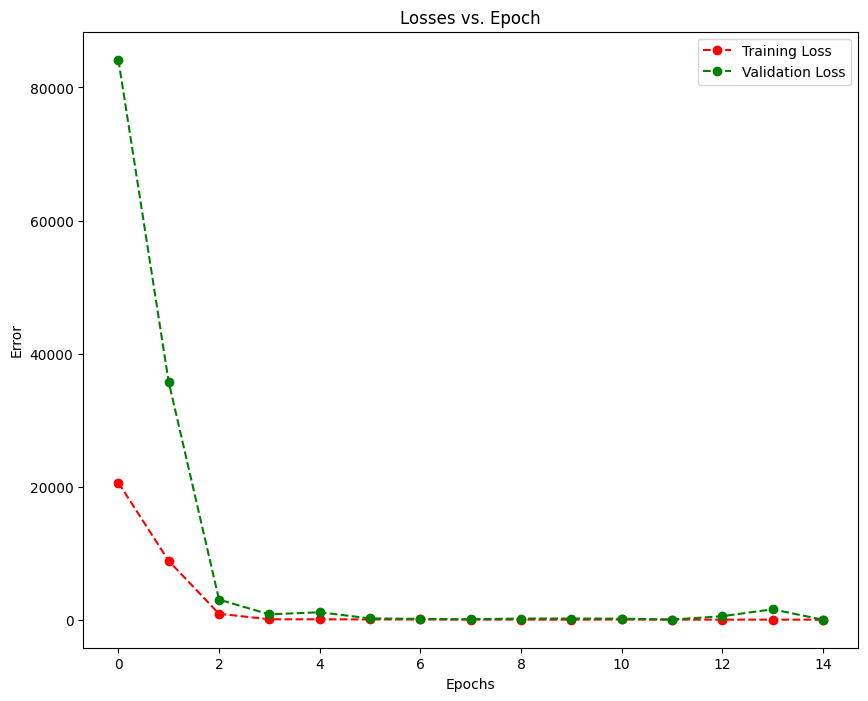

238/238 [==============================] - 3s 8ms/step


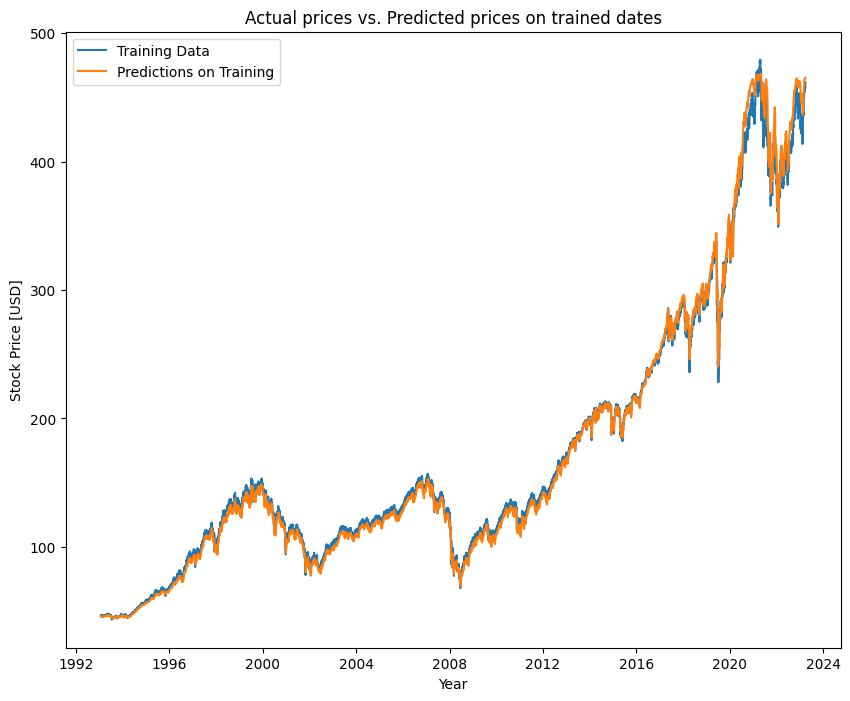

In [52]:
# Visualize training and validation loss
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.plot(history.history['loss'], '--ro', label='Training Loss')
plt.plot(history.history['val_loss'], '--go',  label='Validation Loss')
plt.title('Losses vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Visualize predictions on training data
fig = plt.figure()
fig.set_size_inches(10, 8)
predicitions_on_train = model.predict(x_train).flatten()
plt.plot(train_dates, y_train)
plt.plot(train_dates, predicitions_on_train)
plt.xlabel('Year')
plt.ylabel('Stock Price [USD]')
plt.title('Actual prices vs. Predicted prices on trained dates')
plt.legend(['Training Data', 'Predictions on Training'])
plt.show()

### 5) Forecast stock prices and visualize preformance

After we visualize the performance of the trained model, we can then use it to
predict our parameter of interest, and visualize that as well. If we find our
predictions to be unsatisfactory, we can always go back to the drawing board and
tweak our various hyperparameters.

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 24ms/step


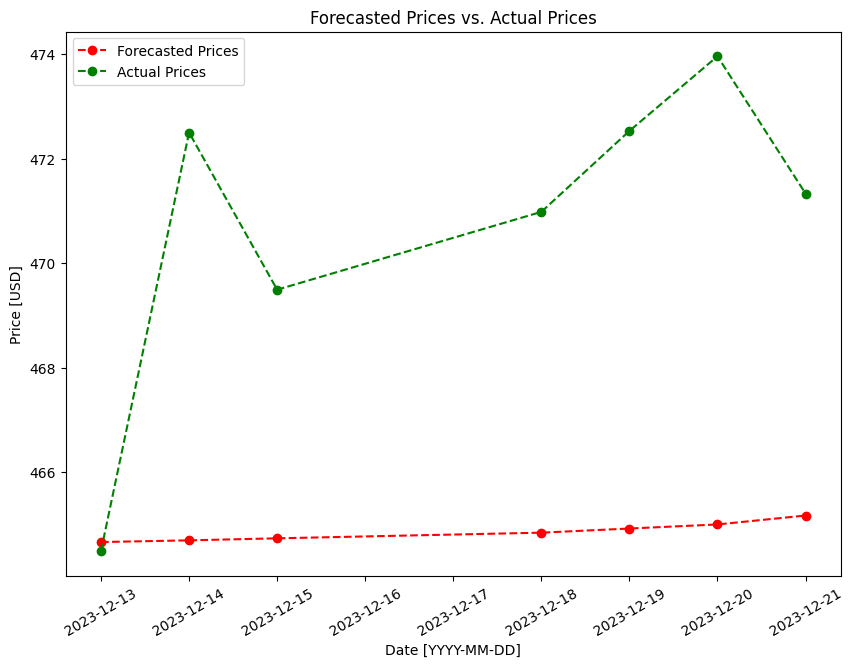

Mean Square Error:  42.53583651448467


In [53]:
# Imports
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.metrics import mean_squared_error
import pandas as pd
################################################################################

# Set business days in US
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Create a vector storing the dates upon which to forecast.
first_forecast_date = ticker_df.index[-1] + pd.Timedelta(days = 1)
forecast_dates = pd.date_range(start   = first_forecast_date,
                               periods = n_predict,
                               freq    = us_bd).to_list()

# Retrieve the true data for the forecasting period to compare with.
verif_df = yf.download(ticker,
                       start = forecast_dates[0],
                       # Download isn't inclusive, and doesn't grab the info
                       # on the end date; add 1 to make sure the data on the end
                       # date is downloaded.
                       end   = forecast_dates[-1] + pd.Timedelta(days = 1))

# Trim the dataframe to only include the parameter we've predicted for, in our
# case, the open.
verif_df = verif_df['Open']

# Forecast
forecast = model.predict(x_train[-n_predict:])

# Set figure dims for our next plot
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.autofmt_xdate()

# Plot the true data against our forecasted data
plt.plot(forecast_dates, forecast, '--ro', label='Forecasted Prices')
plt.plot(forecast_dates, verif_df, '--go', label='Actual Prices')
plt.xticks(rotation=30)
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Price [USD]')
plt.title('Forecasted Prices vs. Actual Prices')
plt.legend()
plt.show()

# Print the mean squared error of the predictions
print('Mean Square Error: ', mean_squared_error(verif_df, forecast))
